# Regression and Classification Decision Trees

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_california_housing, load_iris
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, ShuffleSplit, validation_curve, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, ConfusionMatrixDisplay, classification_report

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_text


np.random.seed(306)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

## Regression using Decision Trees

(Using california housing dataset)

In [2]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

In [3]:
dt_reg_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                            ('dt_reg', DecisionTreeRegressor(max_depth=3, random_state=42))])

dt_reg_cv_results = cross_validate(dt_reg_pipeline, com_train_features, com_train_labels, 
                                   cv=cv, scoring='neg_mean_absolute_error', return_train_score=True, return_estimator=True)

dt_reg_train_error = -1 * dt_reg_cv_results['train_score']
dt_reg_test_error = -1 * dt_reg_cv_results['test_score']

print(dt_reg_train_error.mean(), dt_reg_train_error.std()) # Mean absolute training error
print(dt_reg_test_error.mean(), dt_reg_test_error.std()) # Mean absolute test error

0.5895995682120934 0.004873994610268372
0.5926692636750868 0.006672158499231682


### Visualizing the Decision Tree

In [5]:
dt_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])

**As a graph**

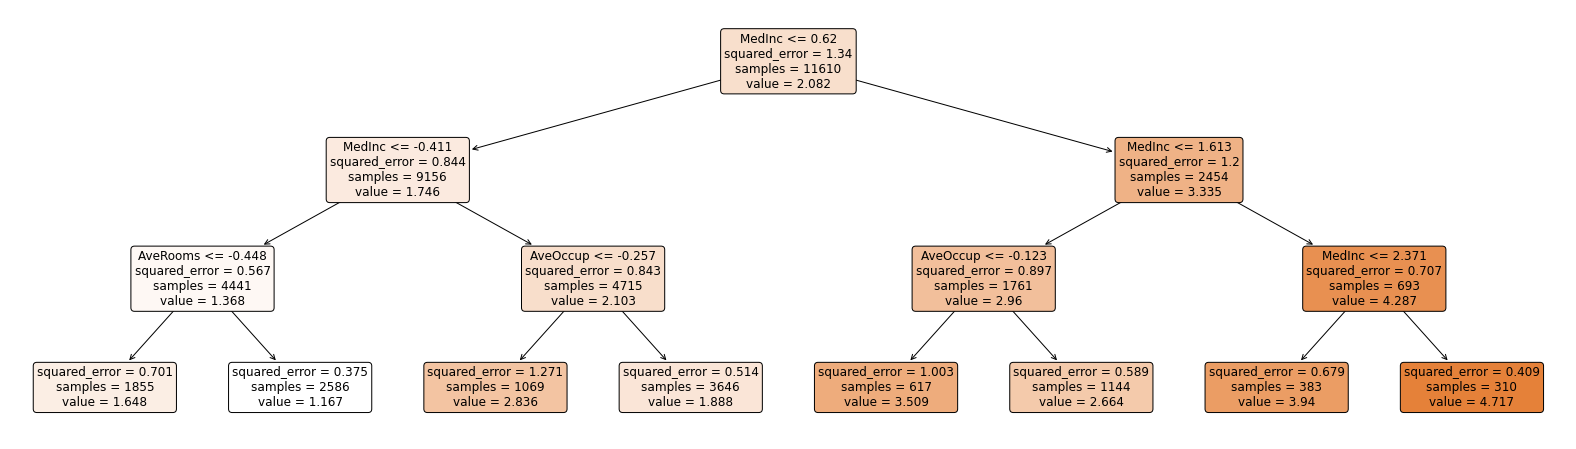

In [6]:
plt.figure(figsize=(28,8), facecolor='w')

a = tree.plot_tree(dt_reg_pipeline[-1], feature_names=features.columns, rounded=True, filled=True, fontsize=12)

**As a text diagram : Converting above plot into a if-else set of rules.**

In [7]:
tree_rules = export_text(dt_reg_pipeline[-1])
print(tree_rules )

|--- feature_0 <= 0.62
|   |--- feature_0 <= -0.41
|   |   |--- feature_2 <= -0.45
|   |   |   |--- value: [1.65]
|   |   |--- feature_2 >  -0.45
|   |   |   |--- value: [1.17]
|   |--- feature_0 >  -0.41
|   |   |--- feature_5 <= -0.26
|   |   |   |--- value: [2.84]
|   |   |--- feature_5 >  -0.26
|   |   |   |--- value: [1.89]
|--- feature_0 >  0.62
|   |--- feature_0 <= 1.61
|   |   |--- feature_5 <= -0.12
|   |   |   |--- value: [3.51]
|   |   |--- feature_5 >  -0.12
|   |   |   |--- value: [2.66]
|   |--- feature_0 >  1.61
|   |   |--- feature_0 <= 2.37
|   |   |   |--- value: [3.94]
|   |   |--- feature_0 >  2.37
|   |   |   |--- value: [4.72]



In [8]:
test_labels_pred = dt_reg_pipeline.predict(test_features)

mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels, test_labels_pred)
r2 = r2_score(test_labels, test_labels_pred)

print(f"MAE: {mae}, MSE: {mse}, r2 score: {r2}")

MAE: 0.6005762942842664, MSE: 0.6417557936098145, r2 score: 0.5150037690483743


### Hyper parameter tuning using `GridSearchCV()`

In [9]:
param_grid = {'dt_reg__max_depth': range(1, 20), 'dt_reg__min_samples_split': range(2, 8)}

dt_grid_search = GridSearchCV(dt_reg_pipeline, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='neg_mean_absolute_error', return_train_score=True)
dt_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('feature_scaling', StandardScaler()),
                                       ('dt_reg',
                                        DecisionTreeRegressor(max_depth=3,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'dt_reg__max_depth': range(1, 20),
                         'dt_reg__min_samples_split': range(2, 8)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [12]:
mean_train_error = -1 * dt_grid_search.cv_results_['mean_train_score'][dt_grid_search.best_index_]
mean_test_error = -1 * dt_grid_search.cv_results_['mean_test_score'][dt_grid_search.best_index_]
std_train_error = -1 * dt_grid_search.cv_results_['std_train_score'][dt_grid_search.best_index_]
std_test_error = -1 * dt_grid_search.cv_results_['std_test_score'][dt_grid_search.best_index_]

print(mean_train_error, std_train_error)
print(mean_test_error, std_test_error)

print(dt_grid_search.best_score_)

print(dt_grid_search.best_params_)

dt_reg_pipeline.set_params(dt_reg__max_depth=11, dt_reg__min_samples_split=5).fit(com_train_features, com_train_labels)

0.27823056836739307 -0.0064898307245129586
0.4283313044233501 -0.011693730815682686
-0.4283313044233501
{'dt_reg__max_depth': 11, 'dt_reg__min_samples_split': 5}


Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=11, min_samples_split=5,
                                       random_state=42))])

Alternatively,

In [13]:
dt_grid_search.best_estimator_.fit(com_train_features, com_train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=11, min_samples_split=5,
                                       random_state=42))])

test_labels_pred = dt_reg_pipeline.predict(test_features)
mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels, test_labels_pred)
r2 = r2_score(test_labels, test_labels_pred)

print(f"MAE: {mae}, MSE: {mse}, r2 score: {r2}")

MAE: 0.4248952183820017, MSE: 0.4154957726373763, r2 score: 0.6859960039130073


## Classification
(Using the abalone dataset)

In [14]:
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
abalone_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data',names=column_names)

abalone_data

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


array([[<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'Diameter'}>,
        <AxesSubplot:title={'center':'Height'}>],
       [<AxesSubplot:title={'center':'Whole weight'}>,
        <AxesSubplot:title={'center':'Shucked weight'}>,
        <AxesSubplot:title={'center':'Viscera weight'}>],
       [<AxesSubplot:title={'center':'Shell weight'}>,
        <AxesSubplot:title={'center':'Rings'}>, <AxesSubplot:>]],
      dtype=object)

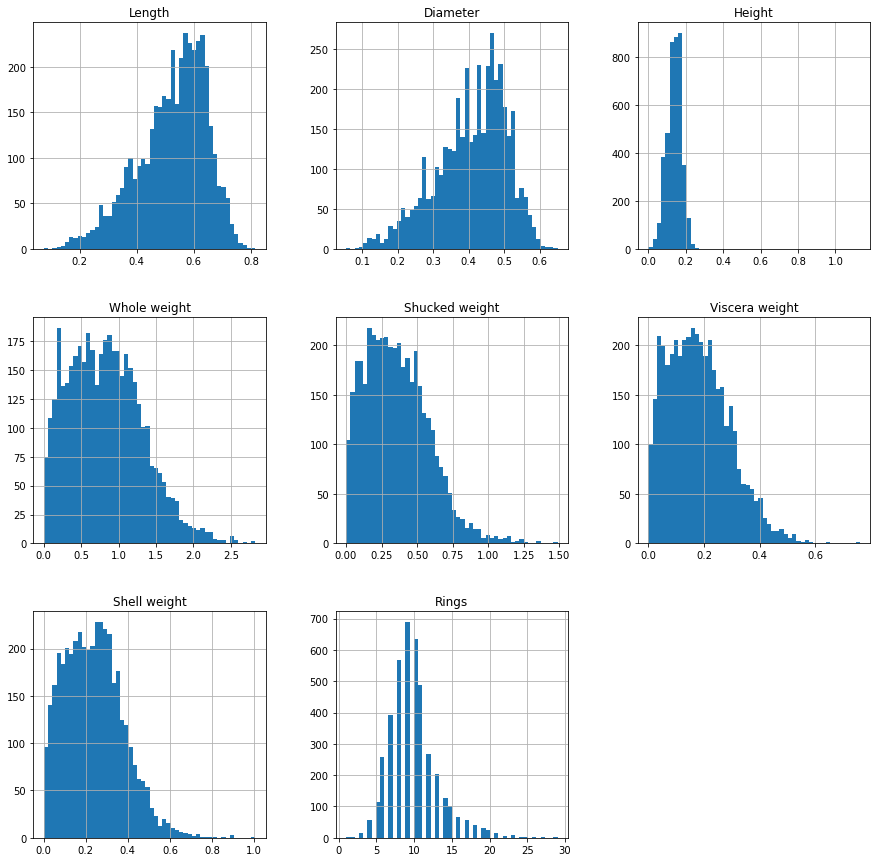

In [15]:
abalone_data.hist(bins=50, figsize=(15, 15))

In [16]:
# sns.pairplot(abalone_data, diag_kind='hist')

<AxesSubplot:>

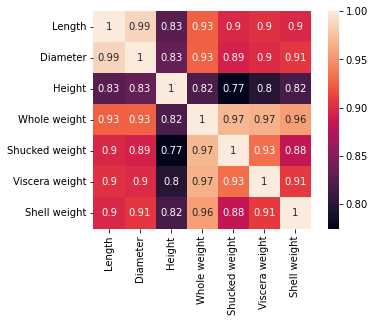

In [17]:
sns.heatmap(abalone_data.iloc[:, :-1].corr(), annot=True, square=True)

<AxesSubplot:>

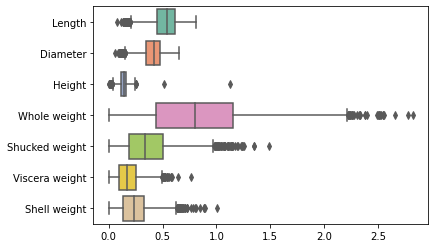

In [18]:
sns.boxplot(data=abalone_data.iloc[:, :-1], orient='h', palette='Set2')

### Data Preprocessing 

In [19]:
means = pd.pivot_table(abalone_data, index=['Sex'], aggfunc={'Height': np.mean})
means

,Height
Sex,
F,0.158011
I,0.107996
M,0.151381


In [22]:
X = abalone_data.iloc[:, :-1]
y = abalone_data.iloc[:, -1]

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4177, 8) (4177,)
(3341, 8) (836, 8) (3341,) (836,)


### Data Transformation using `ColumnTransformer()`

In [28]:
numeric_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
categorical_features = ['Sex']

numeric_transformer = Pipeline([('imputer', SimpleImputer(missing_values=0, strategy='constant', fill_value=0.107996)),
                                ('scaler', StandardScaler())])

# IMPORTANT
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features), 
                                  ('cat', categorical_transformer, categorical_features)])

In [29]:
clf = Pipeline([('preprocessor', preprocessor),
                ('classifier', DecisionTreeClassifier(max_depth=3, random_state=42))])
clf.fit(X_train, y_train)
print(f"Model score: {clf.score(X_test, y_test)}")

Model score: 0.2452153110047847


In [31]:
y_pred = clf.predict(X_test)

# comparison = np.concatenate((y_pred.reshape(len(y_pred), 1), np.array(y_test).reshape(len(y_test), 1)), axis=1)
# for each in comparison:
#     print(each)

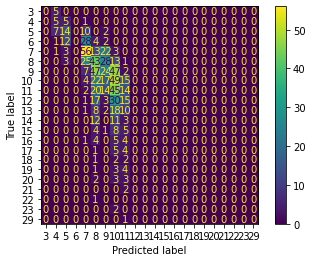

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='0.5g')

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.26      0.45      0.33        11
           5       0.38      0.42      0.40        33
           6       0.00      0.00      0.00        47
           7       0.41      0.57      0.48        98
           8       0.21      0.38      0.27       113
           9       0.21      0.19      0.20       127
          10       0.20      0.46      0.28       107
          11       0.16      0.15      0.16        95
          12       0.00      0.00      0.00        66
          13       0.00      0.00      0.00        39
          14       0.00      0.00      0.00        26
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        14
          17       0.00      0.00      0.00        10
          18       0.00      0.00      0.00         5
          19       0.00      0.00      0.00         8
          20       0.00    

C:\Users\Vishvam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vishvam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vishvam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
acc = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10)
print(f"Accuracy of each fold: {acc * 100}")
print(f'Accuracy: {acc.mean()}')

Accuracy of each fold: [27.46268657 22.45508982 23.95209581 24.5508982  24.25149701 23.95209581
 25.4491018  30.83832335 26.34730539 26.04790419]
Accuracy: 0.25530699794440964


C:\Users\Vishvam\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


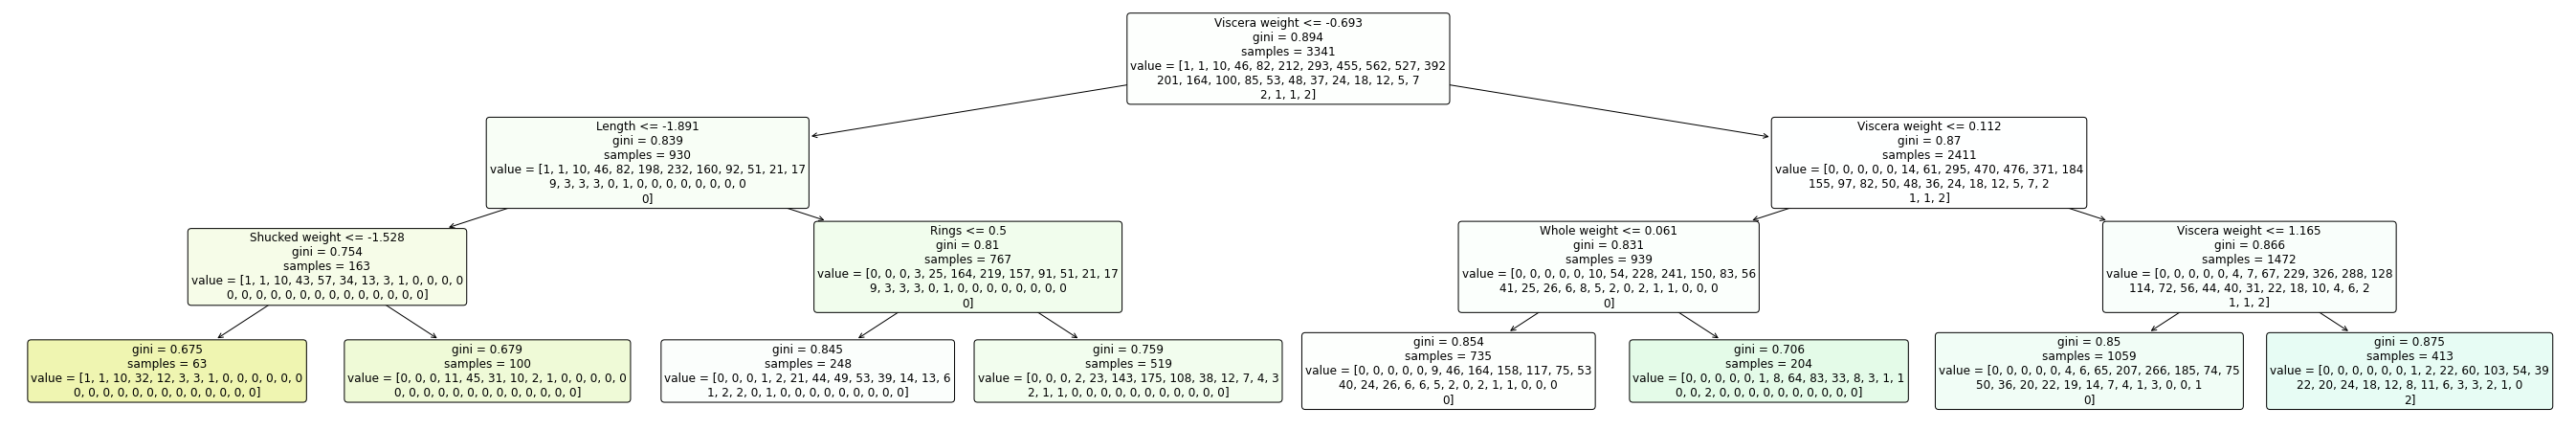

In [36]:
plt.figure(figsize=(48, 8), facecolor='w')
a = tree.plot_tree(clf[-1], feature_names=column_names, rounded=True, filled=True, fontsize=12)
plt.show()

### Hyper parameter tuning using `GridSearchCV()`

In [37]:
X_train_new = preprocessor.fit_transform(X_train)

tuned_parameters = {'max_depth': [1,2,3,4,5,6,7,8,9], 'min_samples_split': [2,4,5,8,10]}
clf_cv = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, scoring='recall_macro')
clf_cv.fit(X_train_new, y_train)

C:\Users\Vishvam\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Vishvam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vishvam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vishvam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` paramet

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 4, 5, 8, 10]},
             scoring='recall_macro')

In [38]:
clf_cv.best_params_

{'max_depth': 5, 'min_samples_split': 4}

In [39]:
# means = clf_cv.cv_results_['mean_test_score']
# stds = clf_cv.cv_results_['std_test_score']
# params = clf_cv.cv_results_['params']
# for mean, std, param in zip(means, stds, params):
#     print(f'{mean} +-{std} for {param}')

In [40]:
clf2 = Pipeline([('preprocessor', preprocessor),
                 ('classifier', DecisionTreeClassifier(max_depth=5, min_samples_split=4, random_state=42))])
clf2.fit(X_train, y_train)
print(clf2.score(X_test, y_test))

0.2715311004784689


**Now, using the Iris dataset**

In [44]:
X, y = load_iris(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_pipeline = Pipeline([('feature_scaling', MinMaxScaler()),
                        ('dt_classifier', DecisionTreeClassifier(max_depth=3, random_state=42))])

dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_scaling', MinMaxScaler()),
                ('dt_classifier',
                 DecisionTreeClassifier(max_depth=3, random_state=42))])

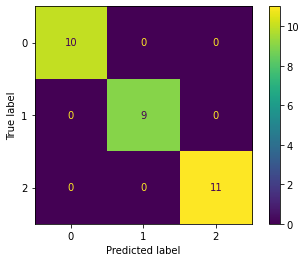

In [45]:
ConfusionMatrixDisplay.from_estimator(dt_pipeline, X_test, y_test)

In [46]:
print(classification_report(y_test, dt_pipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



**Visualizing the Decision Tree**

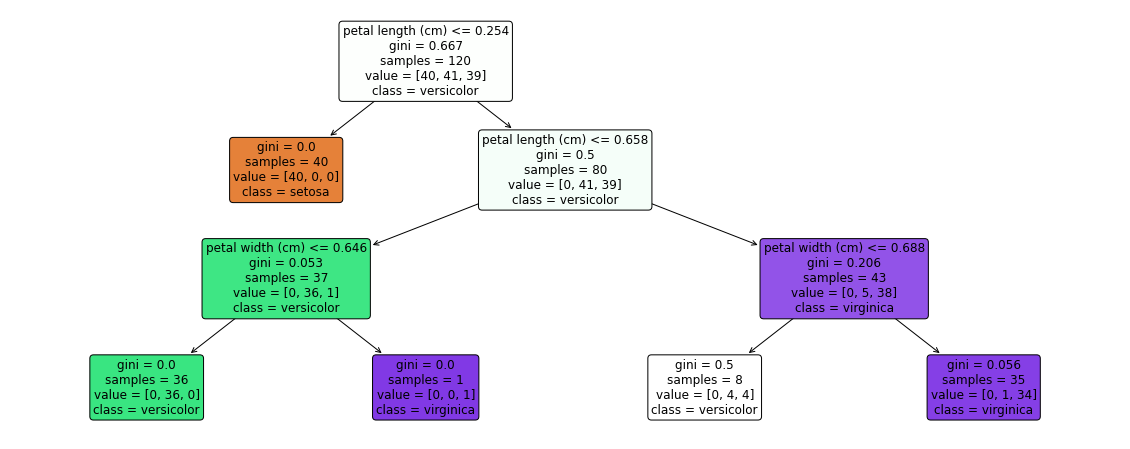

In [48]:
data = load_iris()
plt.figure(figsize=(20, 8), facecolor='w')
a = tree.plot_tree(dt_pipeline[-1], feature_names=data.feature_names, 
                   class_names=data.target_names, rounded=True, filled=True, fontsize=12)

**As a text diagram : Converting above plot into a if-else set of rules.**

In [49]:
tree_rules = export_text(dt_pipeline[-1], feature_names=data.feature_names)
print(tree_rules)

|--- petal length (cm) <= 0.25
|   |--- class: 0
|--- petal length (cm) >  0.25
|   |--- petal length (cm) <= 0.66
|   |   |--- petal width (cm) <= 0.65
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  0.65
|   |   |   |--- class: 2
|   |--- petal length (cm) >  0.66
|   |   |--- petal width (cm) <= 0.69
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  0.69
|   |   |   |--- class: 2



### Feature Importance

In [50]:
importance = pd.DataFrame({'feature': data.feature_names,
                           'importance': np.round(dt_pipeline[-1].feature_importances_, 3)})
importance.sort_values('importance', ascending=False, inplace=True)
print(importance)

             feature  importance
2  petal length (cm)       0.935
3   petal width (cm)       0.065
0  sepal length (cm)       0.000
1   sepal width (cm)       0.000


### Hyper parameter tuning using `GridSearchCV()`

In [52]:
tuned_parameters = {'dt_classifier__max_depth': [1,2,3,4,5], 'dt_classifier__min_samples_split': [2,4,6,8,10]}
clf_cv = GridSearchCV(dt_pipeline, tuned_parameters, scoring='f1_macro')
clf_cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('feature_scaling', MinMaxScaler()),
                                       ('dt_classifier',
                                        DecisionTreeClassifier(max_depth=3,
                                                               random_state=42))]),
             param_grid={'dt_classifier__max_depth': [1, 2, 3, 4, 5],
                         'dt_classifier__min_samples_split': [2, 4, 6, 8, 10]},
             scoring='f1_macro')

In [53]:
clf_cv.best_params_

{'dt_classifier__max_depth': 4, 'dt_classifier__min_samples_split': 2}

In [51]:
# means = clf_cv.cv_results_['mean_test_score']
# stds = clf_cv.cv_results_['std_test_score']
# params = clf_cv.cv_results_['params']
# for mean, std, param in zip(means, stds, params):
#     print(f'{mean} +-{std} for {param}')

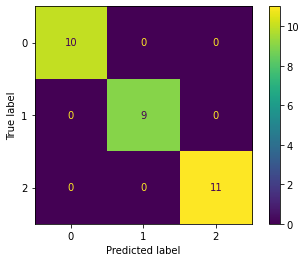

In [54]:
ConfusionMatrixDisplay.from_estimator(clf_cv.best_estimator_, X_test, y_test)